In [1]:
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

paths_to_image = ["TCGA_CS_4943_20000902_18.tif",
                  "TCGA_CS_6665_20010817_18.tif",
                  "TCGA_DU_5855_19951217_23.tif",
                  "TCGA_DU_8166_19970322_25.tif"];

path_to_model = "clf-resnet-weights.hdf5";
model = tf.keras.models.load_model(path_to_model)
img_array = np.empty([len(paths_to_image),256,256,3]);
counter = 0
for path_to_image in paths_to_image:
    img = cv2.imread(path_to_image)
    img = img / 255.0 # we need to normalise (but see what happens if you don't)
    img = np.expand_dims(img, axis=0)
    img_array[counter] = img
    counter += 1
img_array = img_array.astype('float32')

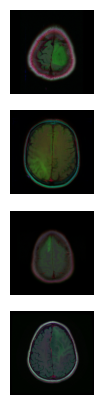

In [2]:
counter = 1
fig = plt.figure(figsize=(5, 5))
for img in img_array:
    fig.add_subplot(len(paths_to_image), 1, counter)
    plt.imshow(img)
    plt.axis('off')
    counter+=1

# Model tested in the images

In [3]:
def map_labels(index):
    return classes[index]

prediction = model.predict(img_array)
max_index_prediction = np.argmax(prediction, axis = 1)
classes = ["No tumour", "Tumour"]
#classes = np.array(classes, dtype = 'U30')
pred_class = [map_labels(i) for i in max_index_prediction]

pred_class

1/1 [==============================] - 2s 2s/step


['Tumour', 'Tumour', 'Tumour', 'Tumour']

# Shap explanation

In [4]:
import shap
shap.initjs()
explainers = []
masks = ['blur(64,64)', 'blur(32,32)', 'blur(128,128)', 'inpaint_telea']

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
shap_values = {}
for mask in masks:
    shap_values_array= []
    masker = shap.maskers.Image(mask, shape=img_array[0].shape) 
    explainer=shap.Explainer(model, masker, output_names=classes, seed = 42)
    for img in img_array:
        shap_values_array.append(explainer(np.expand_dims(img, axis = 0), max_evals = 1000, batch_size = 50, outputs=shap.Explanation.argsort.flip[:1]))
    shap_values[mask] = shap_values_array

Partition explainer: 2it [02:06, 126.45s/it]                                                                           
Partition explainer: 2it [02:02, 122.62s/it]                                                                           
Partition explainer: 2it [02:03, 123.74s/it]                                                                           
Partition explainer: 2it [02:01, 121.36s/it]                                                                           
Partition explainer: 2it [02:02, 122.04s/it]                                                                           
Partition explainer: 2it [02:03, 123.85s/it]                                                                           
Partition explainer: 2it [02:02, 122.02s/it]                                                                           
Partition explainer: 2it [02:02, 122.26s/it]                                                                           
Partition explainer: 2it [02:24, 144.90s

blur(64,64)


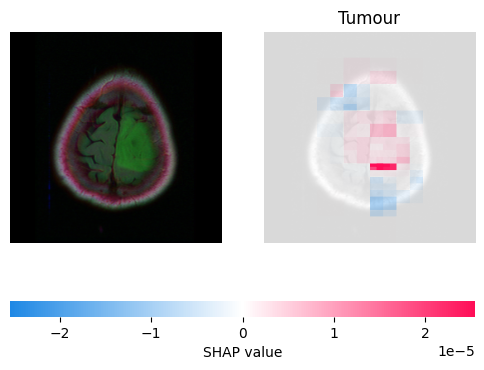

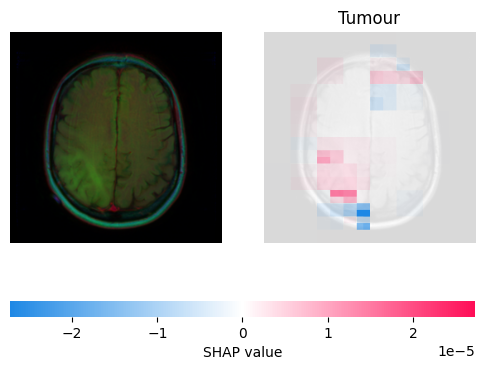

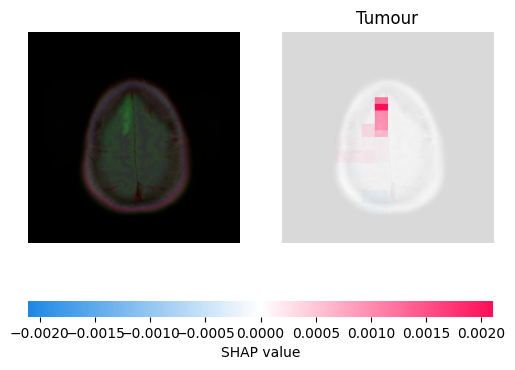

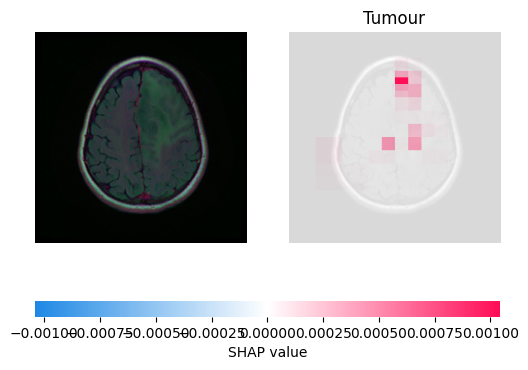

blur(32,32)


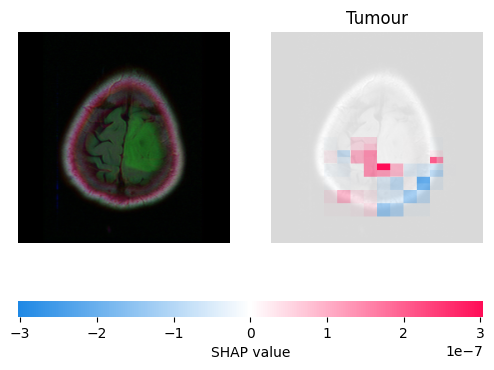

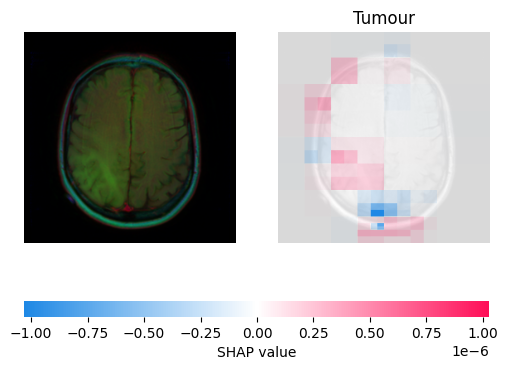

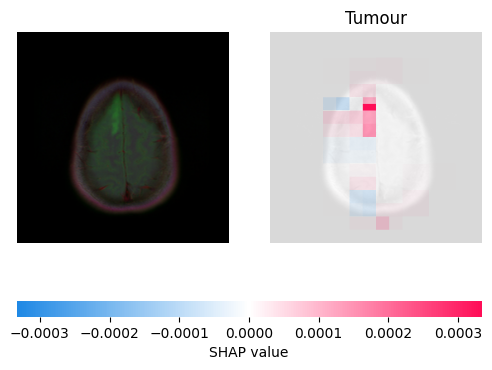

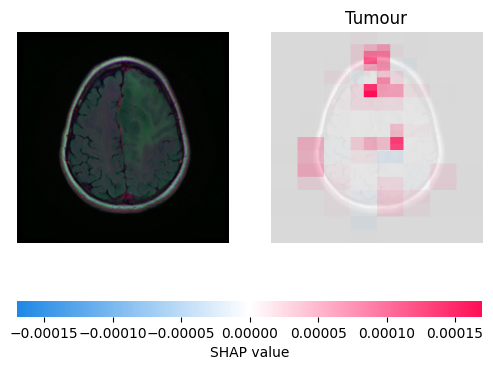

blur(128,128)


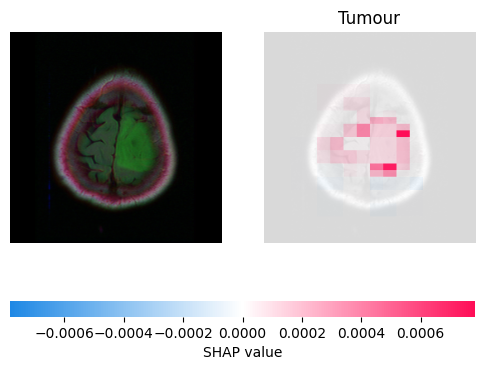

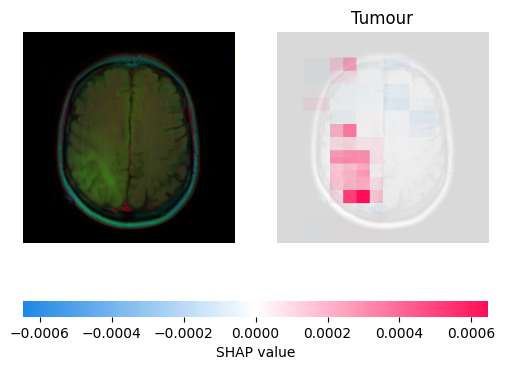

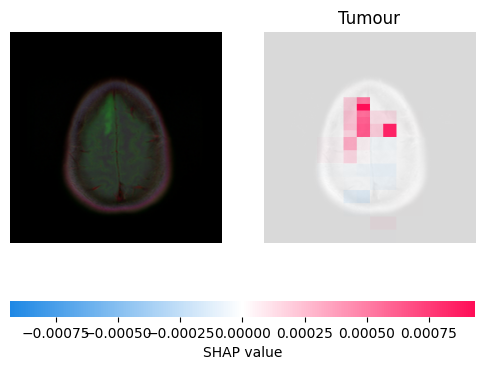

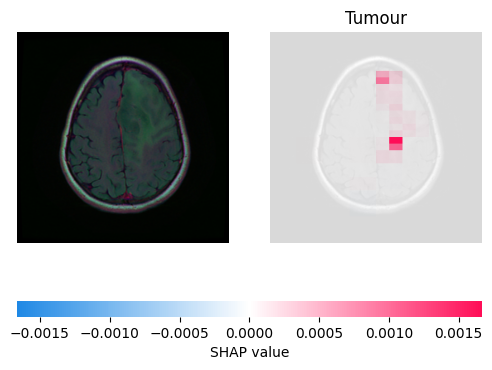

inpaint_telea


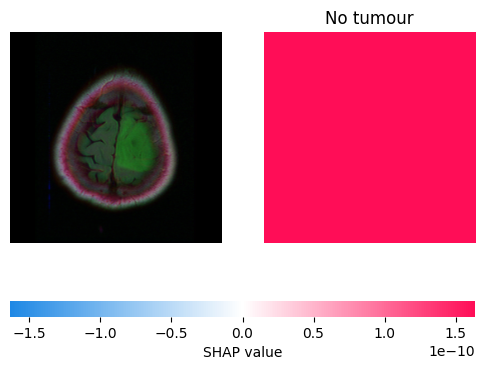

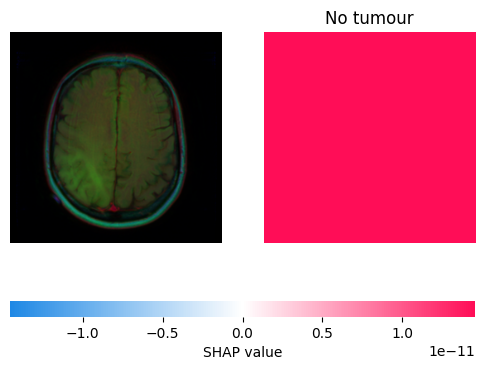

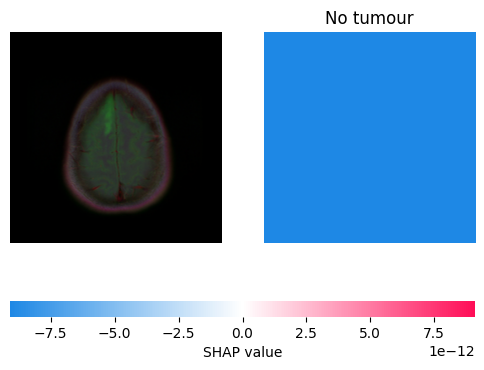

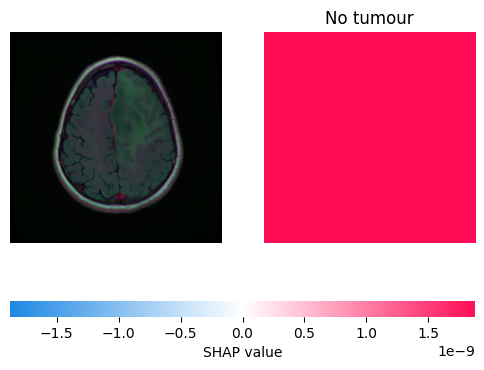

In [6]:
for mask in masks:
    print(mask)
    for shap_value in shap_values[mask]:
        shap.image_plot(shap_value)